# Descrição do projeto

Este projeto visa cirar uma tabela (Data Mart) que serve como referência para análise de atendimentos do CBMDF.

# Imports and Setup

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
plt.rcParams['figure.figsize'] = [15, 7]

flag_logs = False
flag_export_plots = False

datapath = '../SGO_data/'

Matplotlib is building the font cache; this may take a moment.


# Cleaning functions

In [19]:
def string_ate_ponto(string):
    return string.split('.')[0]

def arruma_data_hora(df, coluna):
    df[coluna] = df[coluna].apply(string_ate_ponto)
    df[coluna] = pd.to_datetime(df[coluna], format = '%Y/%m/%d %H:%M:%S')
    return df
    

In [4]:
def time_decompose(df, coluna):
    df[coluna + '_ANO'] = df[coluna].dt.year
    df[coluna + '_MES'] = df[coluna].dt.month
    df[coluna + '_DIASEM'] = df[coluna].dt.dayofweek
    df[coluna + '_HORA'] = df[coluna].dt.hour
    df[coluna + '_HORARIO'] = df[coluna].dt.time
    
    return df

# Extraction

## Extract Functions

In [2]:
# Funções revisadas
# Falta corrigir tipos de dados

def extrai_unidade():
    # Extrai tabela unidade
    unidade_raw = pd.read_csv(datapath + 'TA/TA_UNIDADE.csv')
    
    # Filtra colunas úteis
    cols = ['COD_UNIDADE', 'DSC_UNIDADE', 'COD_AGENCIA', 'COD_TIPO_UNIDADE']  
    unidade = unidade_raw[cols]
    
    # Extrai tabela agencia
    agencia = pd.read_csv(datapath + 'TA/TA_AGENCIA.csv')['COD_AGENCIA DSC_AGENCIA NM_SIGLA'.split()]
    
    # Mescla unidade e agência
    unidade_plus = unidade.merge(agencia, on = 'COD_AGENCIA')[['COD_UNIDADE', 'COD_TIPO_UNIDADE', 'DSC_UNIDADE', 'DSC_AGENCIA', 'NM_SIGLA']]
    
    # Retorna DataFrame ajustado
    return unidade_plus
  
    

In [5]:
def extrai_natureza():
    
    # Natureza
    natureza_raw = pd.read_csv(datapath + 'TA/TA_NATUREZA.csv')
    cols_to_drop = """
    NR_SENASP DT_EXCLUSAO_LOGICA COD_USUARIO_OPER_EXCLUSAO_LOGICA COD_USUARIO_OPER_ULTIMO_UPDATE COD_USUARIO_OPER NR_NATUREZA_INDICE DSC_PUBLICACAO DT_CADASTRO COD_USUARIO_OPER DSC_CODIGO COD_USUARIO_OPER_CADASTRO 
    DT_ULTIMO_UPDATE FLG_ALERTA_GERAL FLG_DESPACHO_IMEDIATO TXT_PROTOCOLO_ATENDIMENTO FLG_AVISO_SONORO DSC_MEDIA_AVISO_SONORO FLG_CAPTURA_PLACA_VEICULO FLG_CAPTURA_PLACA_QUARENTENA
    """.split()
    natureza = natureza_raw.drop(columns = cols_to_drop)
    
    # Natureza_grupo
    natureza_grupo_raw = pd.read_csv(datapath + 'TA/TA_NATUREZA_GRUPO.csv')
    natureza_grupo = natureza_grupo_raw['COD_NATUREZA_GRUPO DSC_NATUREZA_GRUPO'.split()]
    
    # Natureza_subgrupo
    natureza_subgrupo_raw = pd.read_csv(datapath + 'TA/TA_NATUREZA_SUBGRUPO.csv')
    # DSC_COD é utilizado para organizar os painéis de seleção.
    natureza_subgrupo = natureza_subgrupo_raw['COD_NATUREZA_SUBGRUPO COD_NATUREZA_GRUPO DSC_NATUREZA_SUBGRUPO'.split()]

        # Mescla grupo e subgrupo
    natureza_plus1 = natureza.merge(natureza_grupo, on = 'COD_NATUREZA_GRUPO').drop(columns = ['COD_NATUREZA_GRUPO'])
    natureza_plus2 = natureza_plus1.merge(natureza_subgrupo, on = 'COD_NATUREZA_SUBGRUPO').drop(columns = ['COD_NATUREZA_SUBGRUPO'])
    
    return natureza_plus2

In [6]:
def extrai_desfecho():
    desfecho_raw = pd.read_csv(datapath + 'TA/TA_TIPO_DESFECHO.csv')
    desfecho = desfecho_raw[['COD_TIPO_DESFECHO', 'NM_TIPO_DESFECHO']]
    return desfecho

In [7]:
def extrai_local():
    #local_uf_raw = pd.read_csv('data/TA_LOCAL_UF.csv')
    #local_uf = local_uf_raw.drop(columns = 'GM_SHAPE_UF DT_CADASTRO DT_EXCLUSAO_LOGICA COD_USUARIO_OPER'.split())
    local_cidade_raw = pd.read_csv(datapath + 'TA/TA_LOCAL_CIDADE.csv')
    local_cidade = local_cidade_raw.drop(columns = 'GM_SHAPE_CIDADE NU_RA DT_CADASTRO DT_EXCLUSAO_LOGICA COD_USUARIO_OPER'.split())
    local_bairro_raw = pd.read_csv(datapath + 'TA/TA_LOCAL_BAIRRO.csv')
    local_bairro = local_bairro_raw.drop(columns = 'GM_SHAPE_BAIRRO DT_CADASTRO DT_EXCLUSAO_LOGICA COD_USUARIO_OPER '.split())
    
    return local_bairro.merge(local_cidade, on = 'COD_CIDADE')[['COD_BAIRRO', 'DSC_BAIRRO', 'DSC_CIDADE']]
    

In [16]:
def extrai_atendimento(anos): # Passar anos como lista de strings
    lista_df_raw = []
    for i, ano in enumerate(anos):
        lista_df_raw.append(pd.read_csv(datapath + f"TP_ATENDIMENTO/atendimento{ano}.csv"))
    
    atendimento = pd.concat(lista_df_raw)
    atendimento = atendimento.dropna(subset = ['DT_FINALIZADO'])

    cols_to_drop = """
    DT_EXCLUSAO_LOGICA COD_USUARIO_OPER NR_AREA
    """.split()
    
    atendimento = atendimento.drop(columns = cols_to_drop)
    
    # Ajusta tipo dos dados
    atendimento = arruma_data_hora(atendimento, 'DT_CADASTRO')
    
    return atendimento

In [9]:
def extrai_teleatendimento(anos):
    lista_df_raw = []
    for i, ano in enumerate(anos):
        lista_df_raw.append(pd.read_csv(datapath + f"TP_TELE_ATENDIMENTO/tele{ano}.csv"))
    
    teleatendimento = pd.concat(lista_df_raw)

    cols = """
    COD_TELEATENDIMENTO COD_TIPO_TELEATENDIMENTO NR_ATENDIMENTO COD_NATUREZA COD_BAIRRO NR_LATITUDE NR_LONGITUDE LISTA_UNIDADES DT_FATO
    """.split()
    
    # cols = ['COD_TELEATENDIMENTO', 'COD_BAIRRO']
    
    teleatendimento = teleatendimento[cols]
    # teleatendimento = arruma_data_hora(teleatendimento, 'DT_FATO')
    
    teleatendimento.rename(columns = {'COD_NATUREZA':'COD_NATUREZA_INICIAL'}, inplace = True)

    
    return teleatendimento

## Full Extraction Function

In [11]:
def extract_full(anos): # Passar anos como lista de strings
    
    extracted = {}
    
    extracted['unidade'] =  extrai_unidade()
    extracted['natureza'] = extrai_natureza()
    extracted['desfecho'] = extrai_desfecho()
    extracted['local'] = extrai_local()
    extracted['atendimento'] = extrai_atendimento(anos)
    extracted['tele'] = extrai_teleatendimento(anos)
    
    return extracted

## Merge Functions

In [36]:
def merge_dims(all_dfs):
    
    atendimento = all_dfs['atendimento']
    unidade = all_dfs['unidade']
    tele = all_dfs['tele']
    local = all_dfs['local']
    desfecho = all_dfs['desfecho']
    natureza = all_dfs['natureza']
    
    atendimento_plus1 = atendimento.merge(unidade, on = 'COD_UNIDADE').drop(columns = ['COD_UNIDADE'])
    atendimento_plus2 = atendimento_plus1.merge(tele, on = 'COD_TELEATENDIMENTO')
    atendimento_plus3 = atendimento_plus2.merge(local, on = 'COD_BAIRRO').drop(columns = ['COD_BAIRRO'])
    atendimento_plus4 = atendimento_plus3.merge(natureza,  left_on = 'COD_NATUREZA_FINAL', right_on = 'COD_NATUREZA', suffixes = (None, '_FINAL')).drop(columns = ['COD_NATUREZA_FINAL', 'COD_NATUREZA'])
    atendimento_plus5 = atendimento_plus4.merge(natureza,  left_on = 'COD_NATUREZA_INICIAL', right_on = 'COD_NATUREZA', suffixes = (None, '_INICIAL')).drop(columns = ['COD_NATUREZA_INICIAL', 'COD_NATUREZA'])
    atendimento_plus6 = atendimento_plus5.merge(desfecho, left_on = 'COD_TIPO_DEFECHO_OCORRENCIA', right_on = 'COD_TIPO_DESFECHO').drop(columns = ['COD_TIPO_DEFECHO_OCORRENCIA', 'COD_TIPO_DESFECHO'])
    
    
    return atendimento_plus6

# Teste

In [20]:
df = extract_full(['2021'])

anos = ['2021']
i =0
ano =2021
Extraindo antendimento2021


C:\Users\ener.beckmann\AppData\Local\Temp\ipykernel_8060\4014410962.py:4: DtypeWarning: Columns (14,21,23,24,31,42) have mixed types. Specify dtype option on import or set low_memory=False.
  lista_df_raw.append(pd.read_csv(datapath + f"TP_TELE_ATENDIMENTO/tele{ano}.csv"))


In [26]:
for name, frame in df.items():
    print(name)
    print(frame.columns)

unidade
Index(['COD_UNIDADE', 'COD_TIPO_UNIDADE', 'DSC_UNIDADE', 'DSC_AGENCIA',
       'NM_SIGLA'],
      dtype='object')
natureza
Index(['COD_NATUREZA', 'COD_NATUREZA_PAI', 'COD_CONFIG_INSTITUICAO',
       'COD_AGENCIA', 'DSC_NATUREZA', 'DSC_NATUREZA_GRUPO',
       'COD_NATUREZA_GRUPO', 'DSC_NATUREZA_SUBGRUPO'],
      dtype='object')
desfecho
Index(['COD_TIPO_DESFECHO', 'NM_TIPO_DESFECHO'], dtype='object')
local
Index(['COD_BAIRRO', 'DSC_BAIRRO', 'DSC_CIDADE'], dtype='object')
atendimento
Index(['Unnamed: 0', 'COD_ATENDIMENTO', 'COD_TELEATENDIMENTO', 'COD_UNIDADE',
       'COD_NATUREZA_FINAL', 'DSC_HISTORICO', 'DT_FINALIZADO', 'DT_CADASTRO',
       'COD_TIPO_DEFECHO_OCORRENCIA', 'DESTAQUE', 'NR_LATITUDE',
       'NR_LONGITUDE', 'DT_LIBERAR_FECHAMENTO',
       'DSC_TERMO_CIRCUNSTANCIADO_PMDF'],
      dtype='object')
tele
Index(['COD_TELEATENDIMENTO', 'COD_TIPO_TELEATENDIMENTO', 'NR_ATENDIMENTO',
       'COD_NATUREZA', 'COD_BAIRRO', 'NR_LATITUDE', 'NR_LONGITUDE',
       'LISTA_UNIDADES'

In [27]:
df['tele'].rename(columns = {'COD_NATUREZA':'COD_NATUREZA_INICIAL'}, inplace = True)


In [28]:
df['tele'].columns

Index(['COD_TELEATENDIMENTO', 'COD_TIPO_TELEATENDIMENTO', 'NR_ATENDIMENTO',
       'COD_NATUREZA_INICIAL', 'COD_BAIRRO', 'NR_LATITUDE', 'NR_LONGITUDE',
       'LISTA_UNIDADES', 'DT_FATO'],
      dtype='object')

In [37]:
full_df = merge_dims(df)

In [40]:
full_df.to_csv(datapath + 'criados/atendimento_plus.csv')

In [57]:
display(full_df.nunique())

Unnamed: 0                        788485
COD_ATENDIMENTO                   788484
COD_TELEATENDIMENTO               508056
DSC_HISTORICO                     523010
DT_FINALIZADO                     788407
DT_CADASTRO                       648651
DESTAQUE                               2
NR_LATITUDE_x                          0
NR_LONGITUDE_x                         0
DT_LIBERAR_FECHAMENTO             788407
DSC_TERMO_CIRCUNSTANCIADO_PMDF       460
COD_TIPO_UNIDADE                       3
DSC_UNIDADE                           64
DSC_AGENCIA                           11
NM_SIGLA                              11
COD_TIPO_TELEATENDIMENTO               1
NR_ATENDIMENTO                    508043
NR_LATITUDE_y                      27026
NR_LONGITUDE_y                     28241
LISTA_UNIDADES                      1082
DT_FATO                                0
DSC_BAIRRO                           241
DSC_CIDADE                            51
COD_NATUREZA_PAI                      39
COD_CONFIG_INSTI

In [51]:
recanto = full_df[full_df['DSC_CIDADE'] == 'RECANTO DAS EMAS']

In [55]:
recanto_op = recanto[recanto['COD_TIPO_UNIDADE'] == 2]

In [56]:
recanto_op.nunique()

Unnamed: 0                        4894
COD_ATENDIMENTO                   4894
COD_TELEATENDIMENTO               4059
DSC_HISTORICO                     4702
DT_FINALIZADO                     4894
DT_CADASTRO                       4878
DESTAQUE                             1
NR_LATITUDE_x                        0
NR_LONGITUDE_x                       0
DT_LIBERAR_FECHAMENTO             4894
DSC_TERMO_CIRCUNSTANCIADO_PMDF       0
COD_TIPO_UNIDADE                     1
DSC_UNIDADE                         24
DSC_AGENCIA                          1
NM_SIGLA                             1
COD_TIPO_TELEATENDIMENTO             1
NR_ATENDIMENTO                    4059
NR_LATITUDE_y                     2797
NR_LONGITUDE_y                    2846
LISTA_UNIDADES                      35
DT_FATO                              0
DSC_BAIRRO                           2
DSC_CIDADE                           1
COD_NATUREZA_PAI                     6
COD_CONFIG_INSTITUICAO               1
COD_AGENCIA              

In [58]:
import ipywidgets as widgets
from IPython import display

In [59]:
widget1 = widgets.Output()


In [61]:
with widget1:
    display.display(recanto_op)

In [62]:
hbox = widgets.HBox([widget1])

In [63]:
hbox

In [ ]:
full_atendimento = merge_dims(atendimento, tele, unidade, local, natureza)
    sel_atendimento = select_columns(full_atendimento)
    atendimento_filtrado = filter_rows(sel_atendimento)
    
    return atendimento_filtrado

In [104]:
def filtra_operacionais(df):
    df_filtered = df[(df['COD_TIPO_UNIDADE'] == 2) | (df['COD_TIPO_UNIDADE'] == 5) | (df['COD_TIPO_UNIDADE'] == 6)]
    return df_filtered

In [105]:
def filter_rows(df):
    filtered = df.dropna(subset = ['DT_CADASTRO'])
     
    

        
    filtered1 = filtra_operacionais(filtered)
    
    return filtered1

## Column Selection Functions

In [100]:
def select_columns(df):
    print(f"Colunas antes da selecao: {df.columns}")
    columns = ['COD_ATENDIMENTO', 'DT_CADASTRO', 'DSC_UNIDADE', 'COD_TIPO_UNIDADE',  'DSC_AGENCIA', 'NM_SIGLA', 'DSC_BAIRRO', 'DSC_CIDADE', 'DSC_NATUREZA', 'DSC_NATUREZA_GRUPO', 'DSC_NATUREZA_SUBGRUPO']
    return df[columns]


## Row Filtering Functions

## Plot Functions

In [17]:
def plot_groupbar(df, coluna, limit=0, sort = True, nome = ''):
    if sort:
        agrupado = df[['COD_ATENDIMENTO', coluna]].groupby(coluna).count().sort_values(by = 'COD_ATENDIMENTO', ascending=False)
    else:
        agrupado = df[['COD_ATENDIMENTO', coluna]].groupby(coluna).count()

    if limit:
        agrupado.head(limit).plot(kind = 'bar')
    else:  
        agrupado.plot(kind = 'bar')

    if flag_export_plots:
        plt.savefig('plots/' + nome + '_' + coluna + '.png')

# EDA

In [3]:
unidade = extrai_unidade()


In [4]:
unidade.head()

,COD_UNIDADE,COD_TIPO_UNIDADE,DSC_UNIDADE,DSC_AGENCIA,NM_SIGLA
0,1,1,MESA - PCDF,POLÍCIA CIVIL DO DISTRITO FEDERAL,PCDF
1,5,0,ASSISTENTE DE DESPACHO-PCDF,POLÍCIA CIVIL DO DISTRITO FEDERAL,PCDF
2,17,1,MESA 01 - PCDF,POLÍCIA CIVIL DO DISTRITO FEDERAL,PCDF
3,18,1,CEPOL,POLÍCIA CIVIL DO DISTRITO FEDERAL,PCDF
4,19,1,PEL/IC/IML,POLÍCIA CIVIL DO DISTRITO FEDERAL,PCDF


In [106]:
atendimento2021 = extract_full(['2021'])

C:\Users\ENER~1.BEC\AppData\Local\Temp/ipykernel_16000/2697310871.py:9: DtypeWarning: Columns (14,21,23,24,31,42) have mixed types.Specify dtype option on import or set low_memory=False.
  tele = extrai_teleatendimento(anos)


Colunas antes da selecao: Index(['Unnamed: 0', 'COD_ATENDIMENTO', 'COD_TELEATENDIMENTO', 'COD_UNIDADE',
       'COD_NATUREZA_FINAL', 'DT_CADASTRO', 'COD_TIPO_UNIDADE', 'DSC_UNIDADE',
       'DSC_AGENCIA', 'NM_SIGLA', 'COD_BAIRRO', 'DSC_BAIRRO', 'DSC_CIDADE',
       'COD_NATUREZA', 'COD_NATUREZA_PAI', 'COD_CONFIG_INSTITUICAO',
       'COD_AGENCIA', 'DSC_NATUREZA', 'DSC_NATUREZA_GRUPO',
       'COD_NATUREZA_GRUPO', 'DSC_NATUREZA_SUBGRUPO'],
      dtype='object')


In [73]:
atendimento2021.head()

,COD_ATENDIMENTO,DT_CADASTRO,DSC_UNIDADE,DSC_AGENCIA,NM_SIGLA,DSC_BAIRRO,DSC_CIDADE,DSC_NATUREZA,DSC_NATUREZA_GRUPO,DSC_NATUREZA_SUBGRUPO
0,3953334,2021-01-01 00:00:10,MESA 02 - PMDF,POLÍCIA MILITAR DO DISTRITO FEDERAL,PMDF,VILA ESTRUTURAL (GUARÁ),GUARÁ,EM APURAÇÃO,OPERAÇÃO,DE BUSCA E SALVAMENTO
1,3957380,2021-01-02 20:57:24,MESA 01 - DETRAN,DEPARTAMENTO DE TRÂNSITO DO DISTRITO FEDERAL,DETRAN-DF,VILA ESTRUTURAL (GUARÁ),GUARÁ,EM APURAÇÃO,OPERAÇÃO,DE BUSCA E SALVAMENTO
2,3959454,2021-01-03 21:19:19,MESA 02 - PMDF,POLÍCIA MILITAR DO DISTRITO FEDERAL,PMDF,VILA ESTRUTURAL (GUARÁ),GUARÁ,EM APURAÇÃO,OPERAÇÃO,DE BUSCA E SALVAMENTO
3,3961061,2021-01-04 23:30:25,MESA 02 - PMDF,POLÍCIA MILITAR DO DISTRITO FEDERAL,PMDF,VILA ESTRUTURAL (GUARÁ),GUARÁ,EM APURAÇÃO,OPERAÇÃO,DE BUSCA E SALVAMENTO
4,3962686,2021-01-06 04:08:45,MESA 02 - PMDF,POLÍCIA MILITAR DO DISTRITO FEDERAL,PMDF,VILA ESTRUTURAL (GUARÁ),GUARÁ,EM APURAÇÃO,OPERAÇÃO,DE BUSCA E SALVAMENTO


In [71]:
atendimento2021.NM_SIGLA.unique()

array(['PMDF', 'DETRAN-DF', 'PCDF', 'DERDF', 'SAMU', 'CIOB', 'NOVACAP ',
       'METRO-DF', 'CBMDF', 'DF LEGAL', 'SLU'], dtype=object)

In [107]:
atendimento2021_cbmdf = atendimento2021[atendimento2021.NM_SIGLA == 'CBMDF']

In [108]:
atendimento2021_cbmdf_recanto = atendimento2021_cbmdf[atendimento2021_cbmdf.DSC_CIDADE == 'RECANTO DAS EMAS']

In [115]:
atendimento2021_cbmdf_recanto.COD_TIPO_UNIDADE.head()

245618    1
245619    1
245620    2
245621    1
245622    1
Name: COD_TIPO_UNIDADE, dtype: int64

In [116]:
teste_filtrado = atendimento2021_cbmdf_recanto[atendimento2021_cbmdf_recanto.COD_TIPO_UNIDADE == 2]

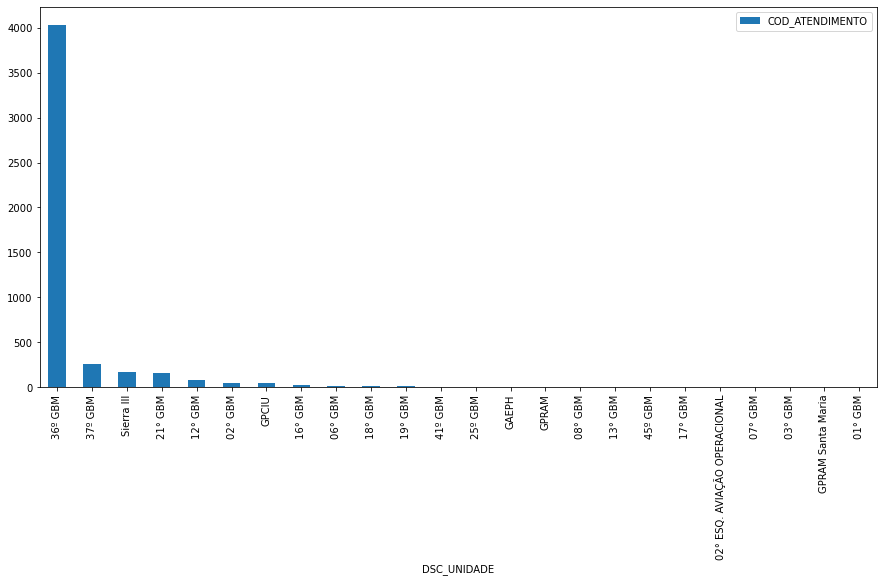

In [117]:
plot_groupbar(teste_filtrado, 'DSC_UNIDADE')

In [118]:
teste_filtrado.shape

(4894, 11)

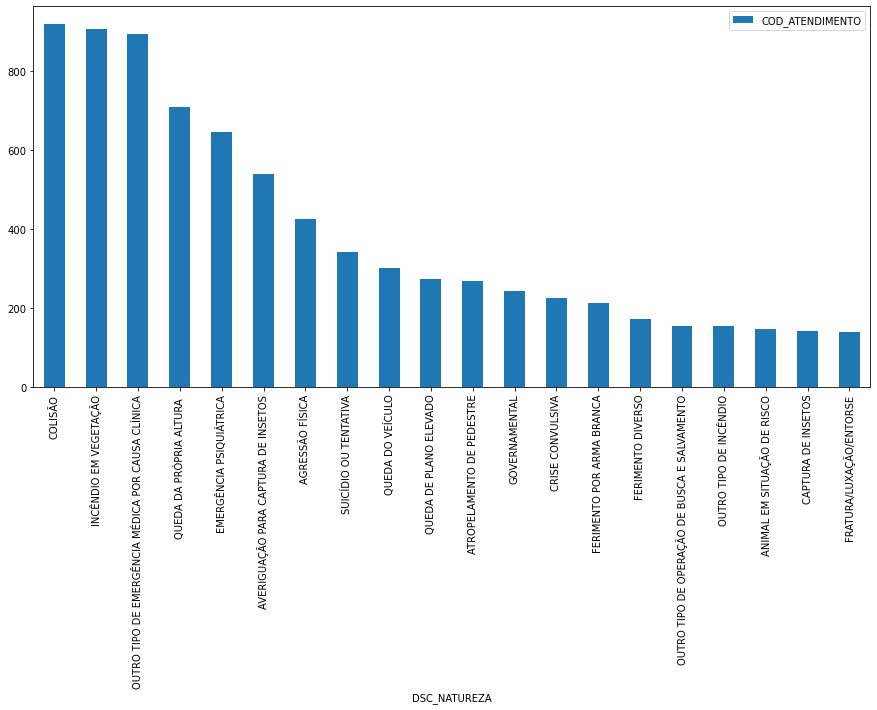

In [110]:
plot_groupbar(atendimento2021_cbmdf_recanto, 'DSC_NATUREZA', limit = 20)

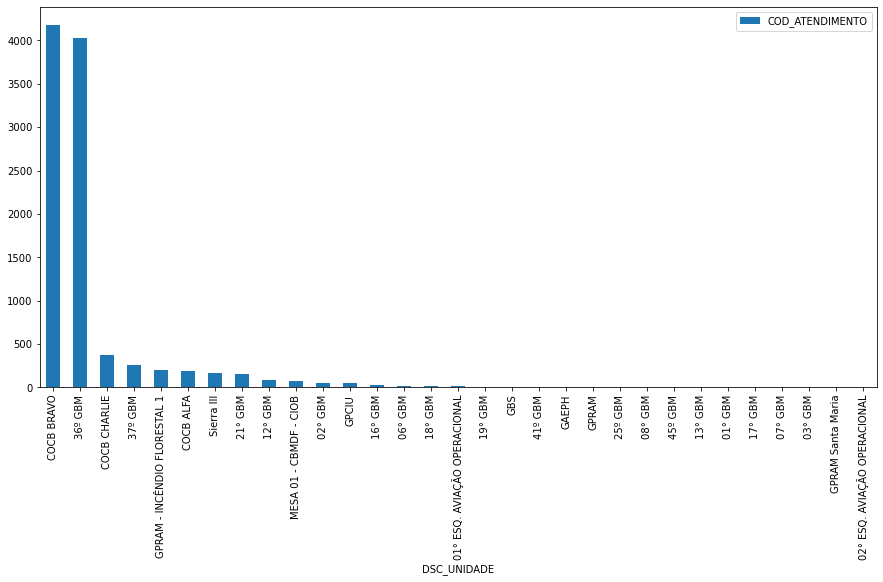

In [111]:
plot_groupbar(atendimento2021_cbmdf_recanto, 'DSC_UNIDADE')



In [78]:
cocb_filter = atendimento2021_cbmdf_recanto.DSC_UNIDADE.str.contains('COCB')



In [82]:
atendimento2021_cbmdf_recanto_filtered = atendimento2021_cbmdf_recanto[~cocb_filter]

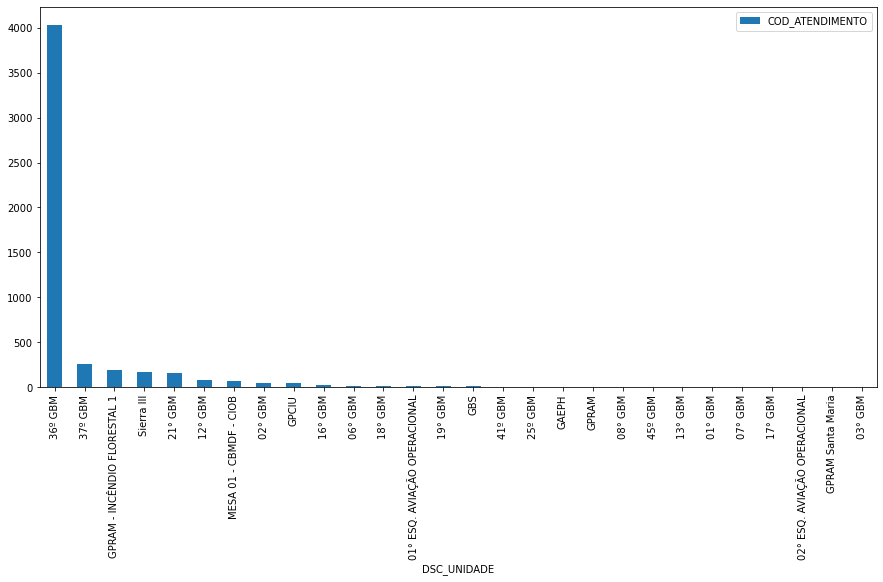

In [83]:
plot_groupbar(atendimento2021_cbmdf_recanto_filtered, 'DSC_UNIDADE')

In [85]:
atendimento2021_cbmdf_recanto_filtered.shape

(5188, 10)

In [26]:
tele2021 = extrai_teleatendimento(['2021'])

C:\Users\ENER~1.BEC\AppData\Local\Temp/ipykernel_16000/3848922975.py:1: DtypeWarning: Columns (14,21,23,24,31,42) have mixed types.Specify dtype option on import or set low_memory=False.
  tele2021 = extrai_teleatendimento(['2021'])


In [27]:
tele2021.head()

,COD_TELEATENDIMENTO,NR_ATENDIMENTO,COD_CIDADE,COD_NATUREZA,NR_LATITUDE,NR_LONGITUDE,LISTA_UNIDADES,DT_FATO
0,12097963,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,12097962,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,12097961,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,12097960,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,12097959,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [28]:
antedimento2021_raw = extrai_atendimento(['2021'])

In [29]:
antedimento2021_raw.head()

,Unnamed: 0,COD_ATENDIMENTO,COD_TELEATENDIMENTO,COD_UNIDADE,COD_NATUREZA_FINAL,DT_CADASTRO
0,443341,3953334,9703978,22,491.0,2021-01-01 00:00:10
1,443342,3953335,9703990,22,491.0,2021-01-01 00:01:38
2,443343,3953336,9703996,22,491.0,2021-01-01 00:02:49
3,443344,3953337,9703996,8,751.0,2021-01-01 00:02:55
4,443345,3953338,9703996,7,752.0,2021-01-01 00:02:55


In [31]:
df2021 = antedimento2021_raw.merge(tele2021, on = 'COD_TELEATENDIMENTO')


In [34]:
local_cidade = pd.read_csv('data/TA_LOCAL_CIDADE.csv')[['COD_CIDADE', 'DSC_CIDADE']]


In [45]:
atendimento2021.shape

(287087, 9)

In [33]:
local = extrai_local()

In [35]:
df2021plus = df2021.merge(local_cidade, on = 'COD_CIDADE')

In [36]:
df2021plus.head()

,Unnamed: 0,COD_ATENDIMENTO,COD_TELEATENDIMENTO,COD_UNIDADE,COD_NATUREZA_FINAL,DT_CADASTRO,NR_ATENDIMENTO,COD_CIDADE,COD_NATUREZA,NR_LATITUDE,NR_LONGITUDE,LISTA_UNIDADES,DT_FATO,DSC_CIDADE
0,443341,3953334,9703978,22,491.0,2021-01-01 00:00:10,2.021010e+15,5578.0,505.0,NaN,NaN,"[{""COD_UNIDADE"":22,""CRITERIO"":""Área de atuação...",NaN,GUARÁ
1,443342,3953335,9703990,22,491.0,2021-01-01 00:01:38,2.021010e+15,5578.0,719.0,NaN,NaN,"[{""COD_UNIDADE"":22,""CRITERIO"":""Área de atuação...",NaN,GUARÁ
2,443343,3953336,9703996,22,491.0,2021-01-01 00:02:49,2.021010e+15,5578.0,669.0,-15.7899,-47.9776,"[{""COD_UNIDADE"":22,""CRITERIO"":""Área de atuação...",NaN,GUARÁ
3,443344,3953337,9703996,8,751.0,2021-01-01 00:02:55,2.021010e+15,5578.0,669.0,-15.7899,-47.9776,"[{""COD_UNIDADE"":22,""CRITERIO"":""Área de atuação...",NaN,GUARÁ
4,443345,3953338,9703996,7,752.0,2021-01-01 00:02:55,2.021010e+15,5578.0,669.0,-15.7899,-47.9776,"[{""COD_UNIDADE"":22,""CRITERIO"":""Área de atuação...",NaN,GUARÁ


# Análise com TELEATENDIMENTO

In [37]:
recanto = df2021plus[df2021plus.DSC_CIDADE == 'RECANTO DAS EMAS']

In [38]:
recanto.count()

Unnamed: 0             35884
COD_ATENDIMENTO        35884
COD_TELEATENDIMENTO    35884
COD_UNIDADE            35884
COD_NATUREZA_FINAL     35884
DT_CADASTRO            35884
NR_ATENDIMENTO         35884
COD_CIDADE             35884
COD_NATUREZA           35884
NR_LATITUDE            11761
NR_LONGITUDE           11761
LISTA_UNIDADES         35883
DT_FATO                    0
DSC_CIDADE             35884
dtype: int64

In [44]:
recanto.LISTA_UNIDADES.iloc[0]

'[{"COD_UNIDADE":22,"CRITERIO":"Área de atuação","SELECIONADA":true},{"COD_UNIDADE":403,"CRITERIO":"Área de atuação","SELECIONADA":false}]'

In [41]:
df2021.shape

(789170, 13)

# Análise antiga sem TELEATENDIMENTO

In [56]:
recanto = atendimento2021[atendimento2021.DSC_CIDADE == 'RECANTO DAS EMAS']

In [57]:
recanto.count()

COD_ATENDIMENTO          35879
DT_CADASTRO              35879
DSC_UNIDADE              35879
DSC_BAIRRO               35879
DSC_CIDADE               35879
DSC_NATUREZA             35879
DSC_NATUREZA_GRUPO       35879
DSC_NATUREZA_SUBGRUPO    35879
COD_TELEATENDIMENTO      35879
dtype: int64

In [59]:
atendimento2021.shape

(788733, 9)

In [62]:
len(recanto.DSC_NATUREZA.unique())

85

In [46]:
recanto_agress = recanto[recanto.DSC_NATUREZA == 'AGRESSÃO FÍSICA']

In [49]:
grouped = recanto_agress.groupby(recanto_agress.DT_CADASTRO.dt.day).count()

In [51]:
grouped['COD_ATENDIMENTO'].head()

DT_CADASTRO
1    6
2    7
3    3
4    6
5    7
Name: COD_ATENDIMENTO, dtype: int64

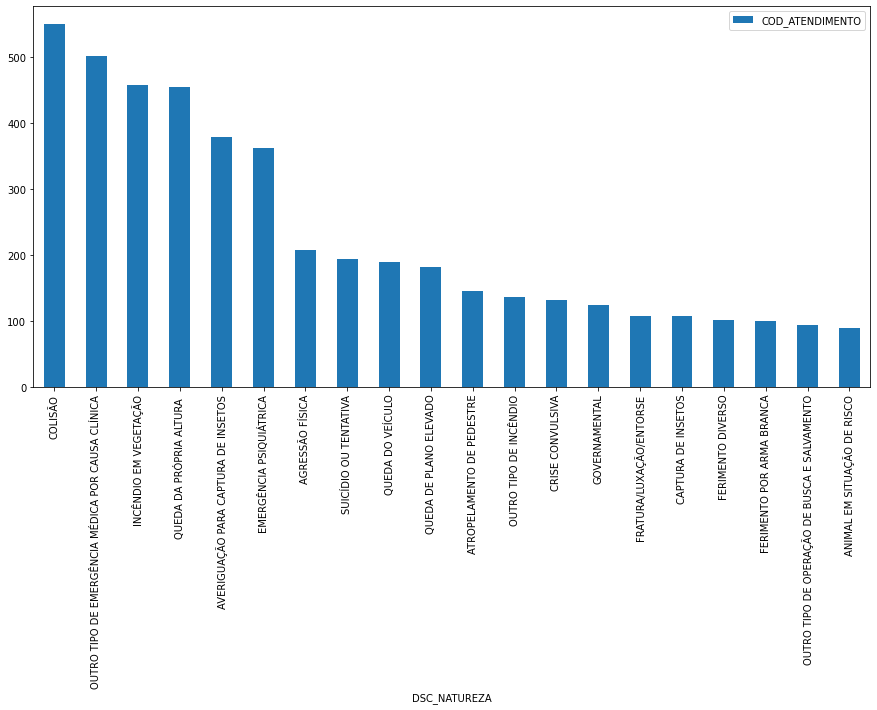

In [40]:
plot_groupbar(recanto, 'DSC_NATUREZA', 20)